# Прогнозирование прибыли с помощью построения корреляционной матрицы, линейной и множественной моделей регрессии

In [225]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import metrics
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [4]:
df=pd.read_csv('50_Startups.csv', sep=',')

In [5]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [28]:
df=df.rename(columns=lambda x: x.lower().replace(' ','_').replace('&','_'))
df.head()

,r_d_spend,administration,marketing_spend,state,profit,summary
0,165349.20,136897.80,471784.10,New York,192261.83,774031.10
1,162597.70,151377.59,443898.53,California,191792.06,757873.82
2,153441.51,101145.55,407934.54,Florida,191050.39,662521.60
3,144372.41,118671.85,383199.62,New York,182901.99,646243.88
4,142107.34,91391.77,366168.42,Florida,166187.94,599667.53


# Определение штата, в котором максимальная прибыль

In [29]:
df.groupby('state').agg({'profit':'sum'}).sort_values('profit', ascending=False)

,profit
state,
New York,1933859.59
Florida,1900384.39
California,1766387.98


Максимальная прибыль в штате Нью-Йорк.

# Сумма расходов на разработку, маркетинговых и административных расходов

In [30]:
df['summary']=df.r_d_spend+df.administration+df.marketing_spend
df.head()

,r_d_spend,administration,marketing_spend,state,profit,summary
0,165349.20,136897.80,471784.10,New York,192261.83,774031.10
1,162597.70,151377.59,443898.53,California,191792.06,757873.82
2,153441.51,101145.55,407934.54,Florida,191050.39,662521.60
3,144372.41,118671.85,383199.62,New York,182901.99,646243.88
4,142107.34,91391.77,366168.42,Florida,166187.94,599667.53


# Доля каждого вида расходов от общей суммы

In [32]:
df['share_r_d_spend']=df.r_d_spend/df.summary
df['share_administration']=df.administration/df.summary
df['share_marketing_spend']=df.marketing_spend/df.summary

df.head()

,r_d_spend,administration,marketing_spend,state,profit,summary,share_r_d_spend,share_administration,share_marketing_spend
0,165349.20,136897.80,471784.10,New York,192261.83,774031.10,0.213621,0.176863,0.609516
1,162597.70,151377.59,443898.53,California,191792.06,757873.82,0.214545,0.199740,0.585716
2,153441.51,101145.55,407934.54,Florida,191050.39,662521.60,0.231602,0.152668,0.615730
3,144372.41,118671.85,383199.62,New York,182901.99,646243.88,0.223402,0.183633,0.592964
4,142107.34,91391.77,366168.42,Florida,166187.94,599667.53,0.236977,0.152404,0.610619


# Количество компаний, у которых значение прибыли больше медианного для каждого штата

In [143]:
median_state=df.groupby('state').agg({'profit':'median'})
median_state

,profit
state,
California,97427.84
Florida,109543.12
New York,108552.04


In [108]:
#Медианное значение прибыли для каждого штата
median_california=median_state.iloc[0][0]
median_florida=median_state.iloc[1][0]
median_newyork=median_state.iloc[2][0]

In [139]:
df[(df['state']=='California') & (df['profit']>median_california)].agg({'profit':'count'})

profit    8
dtype: int64

In [140]:
df[(df['state']=='Florida') & (df['profit']>median_florida)].agg({'profit':'count'})

profit    8
dtype: int64

In [141]:
df[(df['state']=='New York') & (df['profit']>median_newyork)].agg({'profit':'count'})

profit    8
dtype: int64

В каждом исследуемом штате (Калифорния, Флорида, Нью-Йорк) количество компаний, у которых значение прибыли больше медианного для каждого штата, равно 8.

# Количество компаний, у которых значение прибыли больше медианного  для всего датасета

In [142]:
median_df=df.profit.median()
median_df

107978.19

In [158]:
df['median_df']=df.profit>df.profit.median() 

df.query('median_df==True').groupby('state', as_index=False).agg({'profit':'count'}) \
.rename(columns={'profit':'number_of_companies'})

,state,number_of_companies
0,California,7
1,Florida,9
2,New York,9


# Количество компаний, у которых маркетинговые расходы выше 40% и прибыль больше 45 перцентиля

In [152]:
percentile=np.percentile(df.profit, 45)
percentile

105044.57149999999

In [170]:
df.query('share_marketing_spend>0.40 & profit>@percentile').groupby('state', as_index=False) \
.agg({'profit':'count'}).rename(columns={'profit':'number_of_companies'})

,state,number_of_companies
0,California,7
1,Florida,9
2,New York,8


In [166]:
#Среднее значение прибыли по таким компаниям
df_1=df.query('share_marketing_spend>0.40 & profit>@percentile').groupby('state', as_index=False) \
.agg({'profit':'mean'})
df_1

,state,profit
0,California,138998.581429
1,Florida,141850.465556
2,New York,144939.897500


<AxesSubplot:xlabel='state', ylabel='profit'>

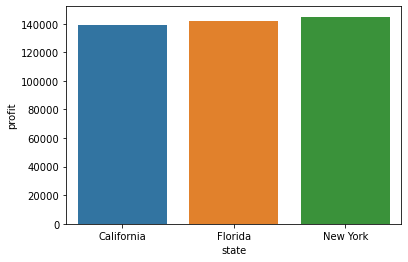

In [167]:
sns.barplot(data=df_1, x='state', y='profit')

# Корреляционная матрица

In [172]:
corr_m=df[['r_d_spend', 'administration', 'marketing_spend', 'profit']].corr()

In [173]:
corr_m

,r_d_spend,administration,marketing_spend,profit
r_d_spend,1.000000,0.241955,0.724248,0.972900
administration,0.241955,1.000000,-0.032154,0.200717
marketing_spend,0.724248,-0.032154,1.000000,0.747766
profit,0.972900,0.200717,0.747766,1.000000


<AxesSubplot:>

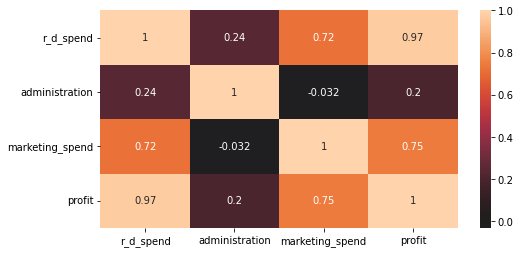

In [175]:
plt.figure(figsize=(8,4))
sns.heatmap(corr_m, center=0, annot=True)

Наибольшую связь с прибылью имеют расходы на разработку (R&D spend) - коэффициент корреляции равен 0.97. 

# Линейная модель регрессии

In [176]:
#Построение линейной модели регрессии с включением фактора R&D spend

In [178]:
X=df['r_d_spend']
y=df['profit']

In [179]:
result=scipy.stats.linregress(X, y)
result

LinregressResult(slope=0.8542913709388089, intercept=49032.899141252135, rvalue=0.9729004656594832, pvalue=3.500322243690248e-32, stderr=0.029305591498200445, intercept_stderr=2537.8969493237905)

При 1 шаге фактора R&D spend переменная profit увеличивается на 0.85. Связь между показателями статистически значимая - p-value<0.05.

In [180]:
#Вычисление коэффициента детерминации
r_sq=result.rvalue**2
r_sq

0.9465353160804392

Построенная линейная модель примерно на 94% объясняет дисперсию (изменчивость) в переменной profit.

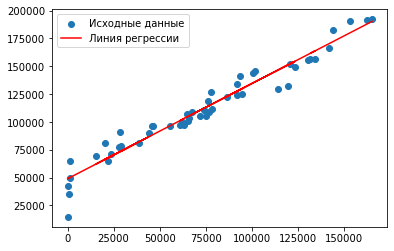

In [181]:
plt.scatter(X, y, label='Исходные данные')
plt.plot(X, result.intercept + result.slope * X, 'r', label='Линия регрессии')
plt.legend()

In [182]:
#Построение линейной модели регрессии с включением фактора Administration

In [183]:
X=df['administration']
y=df['profit']

In [184]:
result=scipy.stats.linregress(X, y)
result

LinregressResult(slope=0.2887492023552266, intercept=76974.47130541757, rvalue=0.20071656826872125, pvalue=0.16221739470358265, stderr=0.20341717021003744, intercept_stderr=25320.183334360594)

Связи между фактором Administration и profit нет - p-value>0.05.

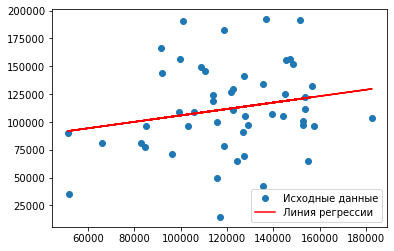

In [185]:
plt.scatter(X, y, label='Исходные данные')
plt.plot(X, result.intercept + result.slope * X, 'r', label='Линия регрессии')
plt.legend()

In [186]:
#Построение линейной модели регрессии с включением фактора Marketing Spend 

In [187]:
X=df['marketing_spend']
y=df['profit']

In [188]:
result=scipy.stats.linregress(X, y)
result

LinregressResult(slope=0.24645926444976782, intercept=60003.5488157717, rvalue=0.7477657217414767, pvalue=4.3810731820309183e-10, stderr=0.0315865823713033, intercept_stderr=7684.530161145417)

При 1 шаге фактора Marketing Spend переменная profit увеличивается на 0.246. Связь между показателями статистически значимая - p-value<0.05.

In [189]:
#Вычисление коэффициента детерминации
r_sq=result.rvalue**2
r_sq

0.5591535746115516

Построенная линейная модель примерно на 56% объясняет дисперсию (изменчивость) в переменной profit. Коэффициент детерминации невысокий, но приемлимый.

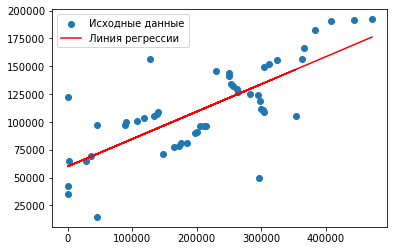

In [190]:
plt.scatter(X, y, label='Исходные данные')
plt.plot(X, result.intercept + result.slope * X, 'r', label='Линия регрессии')
plt.legend()

# Модель множественной регрессии

In [231]:
#Исключаем зависимую переменную
X_mult=df[['r_d_spend', 'administration', 'marketing_spend']]
y=df['profit']
X_mult.head()

,r_d_spend,administration,marketing_spend
0,165349.20,136897.80,471784.10
1,162597.70,151377.59,443898.53
2,153441.51,101145.55,407934.54
3,144372.41,118671.85,383199.62
4,142107.34,91391.77,366168.42


In [232]:
#Добавляем константу
X_mult['const']=1
X_mult.head()

/var/folders/4f/zkg9tmbs22l_kzpykf2vs61h0000gn/T/ipykernel_1931/904389008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_mult['const']=1


,r_d_spend,administration,marketing_spend,const
0,165349.20,136897.80,471784.10,1
1,162597.70,151377.59,443898.53,1
2,153441.51,101145.55,407934.54,1
3,144372.41,118671.85,383199.62,1
4,142107.34,91391.77,366168.42,1


In [233]:
model=sm.OLS(y, X_mult)
result_mult=model.fit()
print(result_mult.summary())

                            OLS Regression Results                            
Dep. Variable:                 profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     296.0
Date:                Sun, 20 Nov 2022   Prob (F-statistic):           4.53e-30
Time:                        15:58:27   Log-Likelihood:                -525.39
No. Observations:                  50   AIC:                             1059.
Df Residuals:                      46   BIC:                             1066.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
r_d_spend           0.8057      0.045     

Коэффициент детерминации равен 0.948. Выбранная модель объясняет 94.8% дисперсии в переменной profit.

Статистически значимым коэффициентом регрессии является коэффициент фактора R&D spend (p-value<0.05). Оставшиеся 2 фактора являются незначимыми. При 1 шаге фактора R&D spend переменная profit увеличивается на 0.8057.

Так как 2 из 3 фактора являются незначимыми, а также из-за мультиколлинеарности факторов R&D spend и Marketing Spend, данную модель лучше не использовать для прогнозирования. 

**Для прогнозирования лучше всего использовать однофакторную линейную модель регрессии с включением фактора R&D spend.**